In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import os
import warnings



In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/modified_utc_dataset.csv')
print(data.head(4))

   Duration Protocol Direction State  Source_Type_of_Service  \
0  1.026539      tcp        ->  S_RA                     0.0   
1  1.009595      tcp        ->  S_RA                     0.0   
2  3.056586      tcp        ->  SR_A                     0.0   
3  3.111769      tcp        ->  SR_A                     0.0   

   Destination_Type_of_Service  Total_Packets  Total_Bytes  Source_Bytes  \
0                          0.0              4          276           156   
1                          0.0              4          276           156   
2                          0.0              3          182           122   
3                          0.0              3          182           122   

                                    Label  
0  flow=Background-Established-cmpgw-CVUT  
1  flow=Background-Established-cmpgw-CVUT  
2             flow=Background-TCP-Attempt  
3             flow=Background-TCP-Attempt  


In [4]:
# we have seen that our data has 10 columns
print(data.dtypes)

Duration                       float64
Protocol                        object
Direction                       object
State                           object
Source_Type_of_Service         float64
Destination_Type_of_Service    float64
Total_Packets                    int64
Total_Bytes                      int64
Source_Bytes                     int64
Label                           object
dtype: object


In [5]:
print(data.head(4).info)

<bound method DataFrame.info of    Duration Protocol Direction State  Source_Type_of_Service  \
0  1.026539      tcp        ->  S_RA                     0.0   
1  1.009595      tcp        ->  S_RA                     0.0   
2  3.056586      tcp        ->  SR_A                     0.0   
3  3.111769      tcp        ->  SR_A                     0.0   

   Destination_Type_of_Service  Total_Packets  Total_Bytes  Source_Bytes  \
0                          0.0              4          276           156   
1                          0.0              4          276           156   
2                          0.0              3          182           122   
3                          0.0              3          182           122   

                                    Label  
0  flow=Background-Established-cmpgw-CVUT  
1  flow=Background-Established-cmpgw-CVUT  
2             flow=Background-TCP-Attempt  
3             flow=Background-TCP-Attempt  >


## Feature exploration 

In [6]:
data.describe()

,Duration,Source_Type_of_Service,Destination_Type_of_Service,Total_Packets,Total_Bytes,Source_Bytes
count,1.621173e+06,1.616028e+06,1.529939e+06,1.621173e+06,1.621173e+06,1.621173e+06
mean,7.506621e+02,4.787046e-03,7.614683e-04,4.293056e+01,3.345778e+04,7.174597e+03
std,1.218352e+03,4.626329e-01,4.368807e-02,4.124564e+03,4.239958e+06,2.453215e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00
25%,4.504000e-03,0.000000e+00,0.000000e+00,2.000000e+00,2.680000e+02,8.200000e+01
50%,2.021557e+00,0.000000e+00,0.000000e+00,4.000000e+00,5.410000e+02,1.860000e+02
75%,1.427422e+03,0.000000e+00,0.000000e+00,1.000000e+01,1.520000e+03,7.840000e+02
max,3.600031e+03,1.920000e+02,3.000000e+00,2.686731e+06,2.689640e+09,2.635366e+09


The median of Duration, Source_Type_of_Service, Destination_type, and Total_Packtes are extremely close to the minimum value. Likewise, the Total_Bytes and the Source_byte's median are also closer to the minimum compared to the maximum. So it suggests our data is skewed to the left. The above statistical description can be visualized as follows.

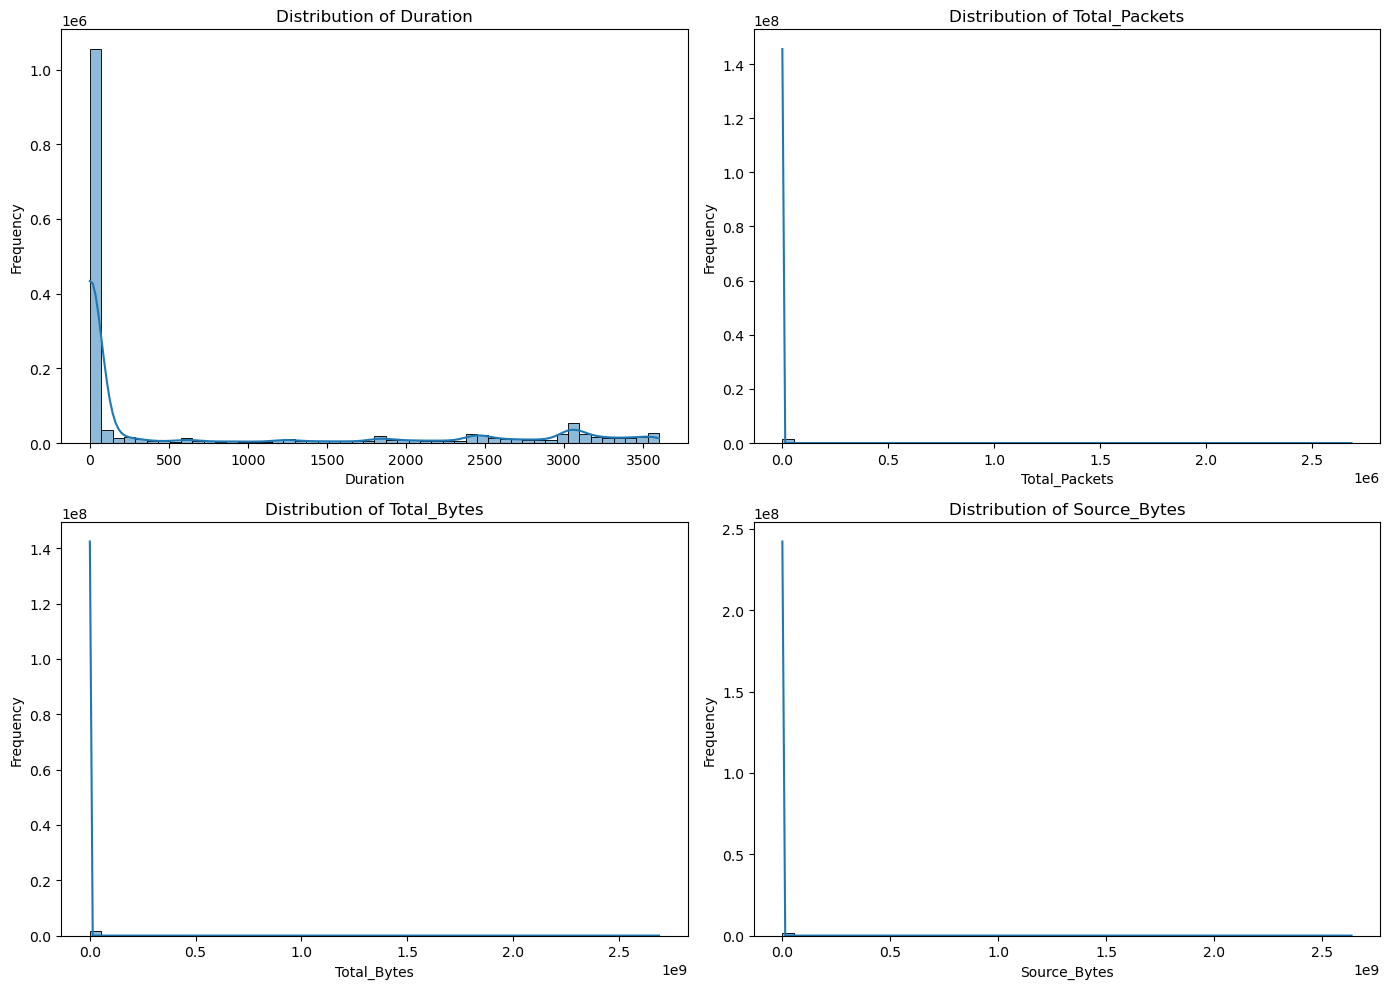

In [7]:
# List of columns to visualize
columns_to_visualize = ['Duration', 'Total_Packets', 'Total_Bytes', 'Source_Bytes']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_visualize):
    sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The distribution of all four features suggests that the data is left-skewed. Those features might also correlate with one another since the duration of someone's internet usage affects the total packets and also the total bytes. Except for some observations, almost all of them have a value around zero.
## Feature relationship 

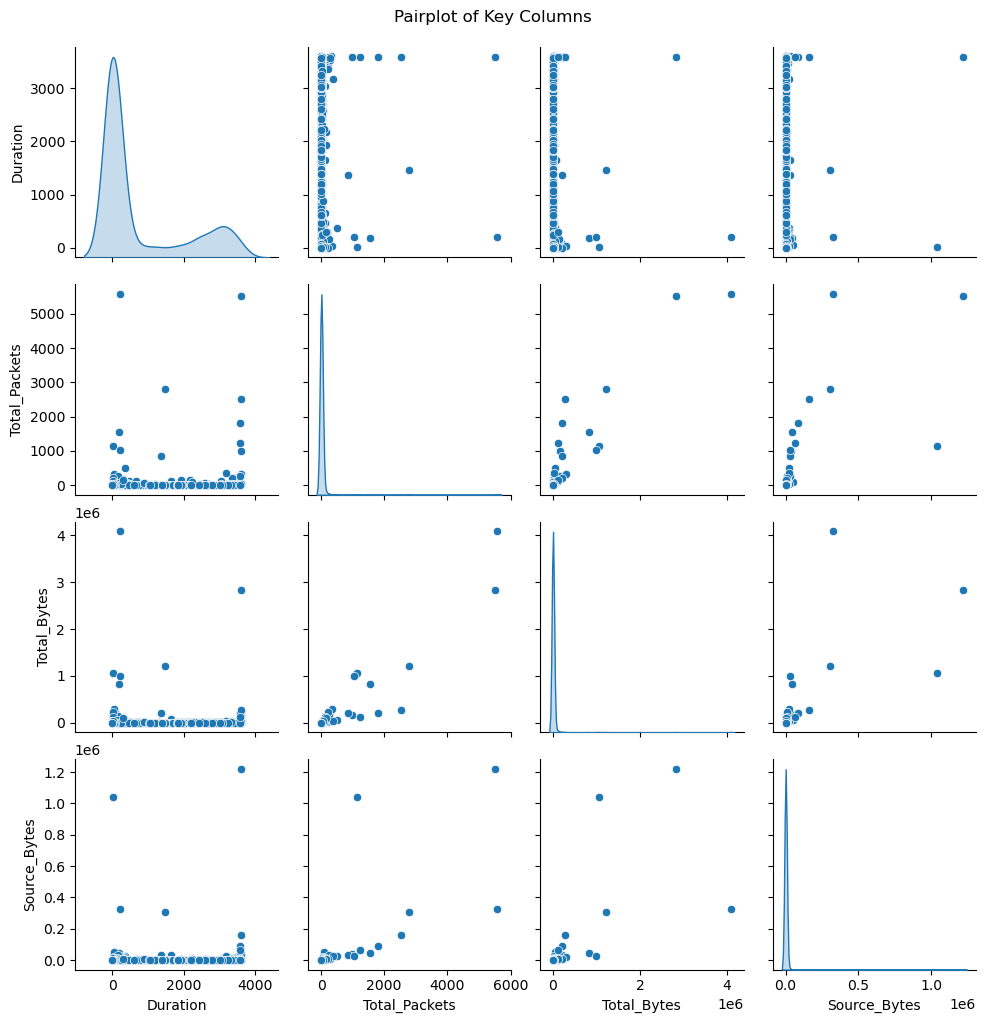

In [19]:
# relation between numerical features. 
sampled_data = data.sample(n=2000, random_state=22)

sns.pairplot(sampled_data[columns_to_visualize], diag_kind='kde')  # Change diag_kind to 'hist' or 'kde'
plt.suptitle('Pairplot of Key Columns', y=1.02)
plt.show()


- **Relation Between Numerical Features**
    - When analyzing the pair plot of the numerical features, it's evident that the scatter plots between different variables show no discernible pattern or trend for the 'Duration' feature. The distribution appears to be scattered around zero for any change in duration, indicating a lack of linear relationship with other numerical features.
    - However, features like 'Source_Bytes' exhibit a linear pattern in the scatter plots. This is further supported by the correlation matrix, which shows a correlation coefficient of more than 0.6 between 'Source_Bytes' and other features like 'Total_Packets' and 'Total_Bytes'.
    - Similarly, 'Total_Packets' and 'Total_Bytes' demonstrate a strong linear relationship in the scatter plots, evidenced by their perfect correlation in the correlation matrix.
iable. 

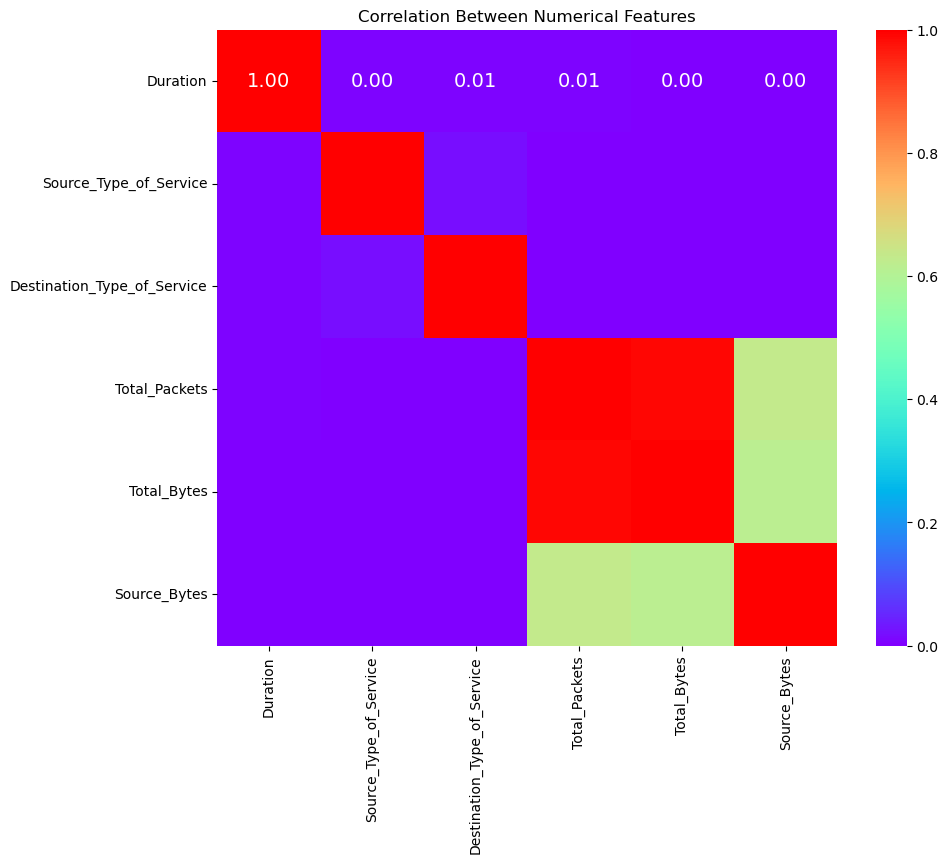

In [17]:
numerical_df = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='rainbow', fmt=".2f", annot_kws={"size": 14})
plt.title('Correlation Between Numerical Features')
plt.show()


From the correlation histogram, we found out that only total packet, total bytes, and source bytes have a correlation. The duration, the destination and the source had zero correlation which is important for building a model. 

# Relation between Features and the Target varible 

### Categorizing Data Based on Labels

The target variables are whether the network connection flow is labeled as from a botnet or not. To meet this objective, we need to identify the specific phrases indicating botnet activity within the `label` column and create a new column called `Suspicious` to encode this information.

**Step 1: Identify Botnet Labels and Create Suspicious Column**

First, we identify the labels in the `label` column that indicate botnet activity. We then create a new column called `Suspicious` and encode it as `1` if the flow is from a botnet, otherwi.
rvation.


The next step will be encoding the label column into suspicious and non-suspicious. To do that we can create another column called Suspicious. 

**Step 2: Aggregate Data Based on Suspicious Column**

Next, we aggregate the data based on the `Suspicious` column to analyze the number of each observation.

In [20]:
data['Suspicious'] = data['Label'].apply(lambda x: 1 if 'flow=From-Botnet' in x else 0)

# Aggregate the data based on the 'Suspicious' column
suspicious_counts = data['Suspicious'].value_counts()

print(suspicious_counts)
data.head()

Suspicious
0    1587187
1      33986
Name: count, dtype: int64


,Duration,Protocol,Direction,State,Source_Type_of_Service,Destination_Type_of_Service,Total_Packets,Total_Bytes,Source_Bytes,Label,Suspicious
0,1.026539,tcp,->,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0
1,1.009595,tcp,->,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0
2,3.056586,tcp,->,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0
3,3.111769,tcp,->,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0
4,3.083411,tcp,->,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0


In [28]:
# Filter the data where Suspicious = 1 and non_Suspicious =0
suspicious_df = data[data['Suspicious'] == 1]
non_suspicious_df = data[data['Suspicious'] == 0]

# List of features to plot
features = [
    ('Source_Type_of_Service', 'Source type', 'Source_type'),
    ('Destination_Type_of_Service', 'Destination type', 'Destination type'),
    ('Duration', 'Duration', 'Duration (seconds)'),
    ('Total_Packets', 'Total Packets', 'Total Packets')
]

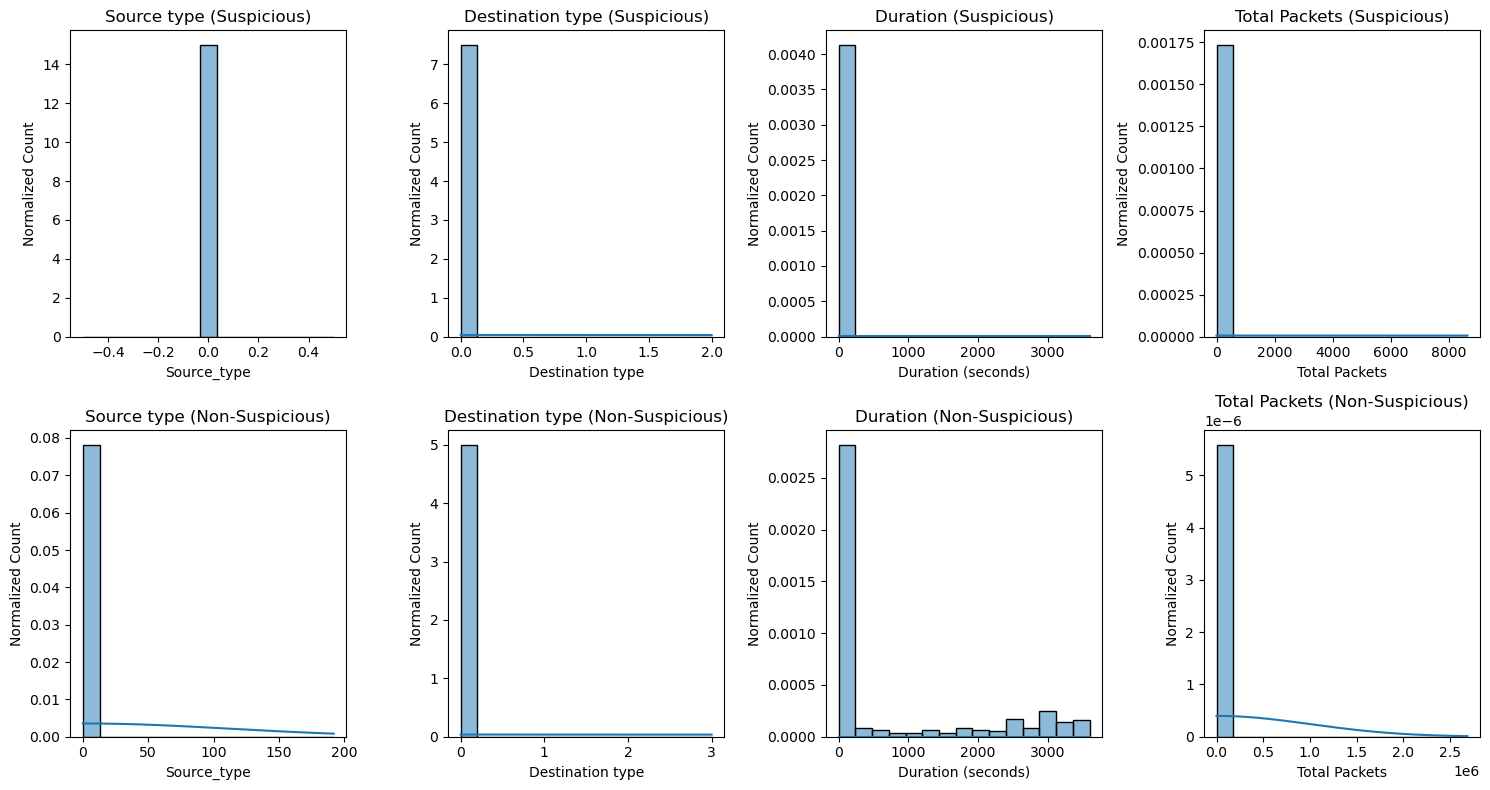

In [33]:
plt.figure(figsize=(15, 8))

# Calculate the bandwidth for KDE
bandwidth = max(suspicious_df[feature].std(), non_suspicious_df[feature].std())

# Plot suspicious data
for idx, (feature, title, xlabel) in enumerate(features, start=1):
    plt.subplot(2, 4, idx)
    sns.histplot(suspicious_df[feature], bins=15, kde = True, kde_kws={'bw_adjust': bandwidth}, stat='density')
    plt.title(title+' (Suspicious)')
    plt.xlabel(xlabel)
    plt.ylabel('Normalized Count')

# Plot non-suspicious data
for idx, (feature, title, xlabel) in enumerate(features, start=5):
    plt.subplot(2, 4, idx)
    sns.histplot(non_suspicious_df[feature], bins=15, kde=True, kde_kws={'bw_adjust': bandwidth}, stat='density')
    plt.title(title+' (Non-Suspicious)')
    plt.xlabel(xlabel)
    plt.ylabel('Normalized Count')

plt.tight_layout()
plt.show()

**The insights from the distribution graph are:** 
- The distribution of 'Source_Type_of_Service' for suspicious data appears concentrated at the center around zero. This implies the most frequent Source_type is also the botnet target. For the non-suspicious, some observations have values ranging from 0-200. This could suggest a variety of sources for the non-suspicious traffic, potentially reflecting legitimate and varied sources interacting with the network.
  
- The distribution of 'Destination_Type_of_Service' and the 'Total_Packet' distribution is more or less the same for the suspicious and non-suspicious.
- The distribution of 'Duration' for suspicious data appears extremely frequent around the short-lived ones around zero. But for the nonsuspicious thought the most frequent observation is short-lived there are many observation which has a duration of over 1000 seconds. This also leads us to investigate the botnets related to the connectivity 'State' of the network devices.  
  

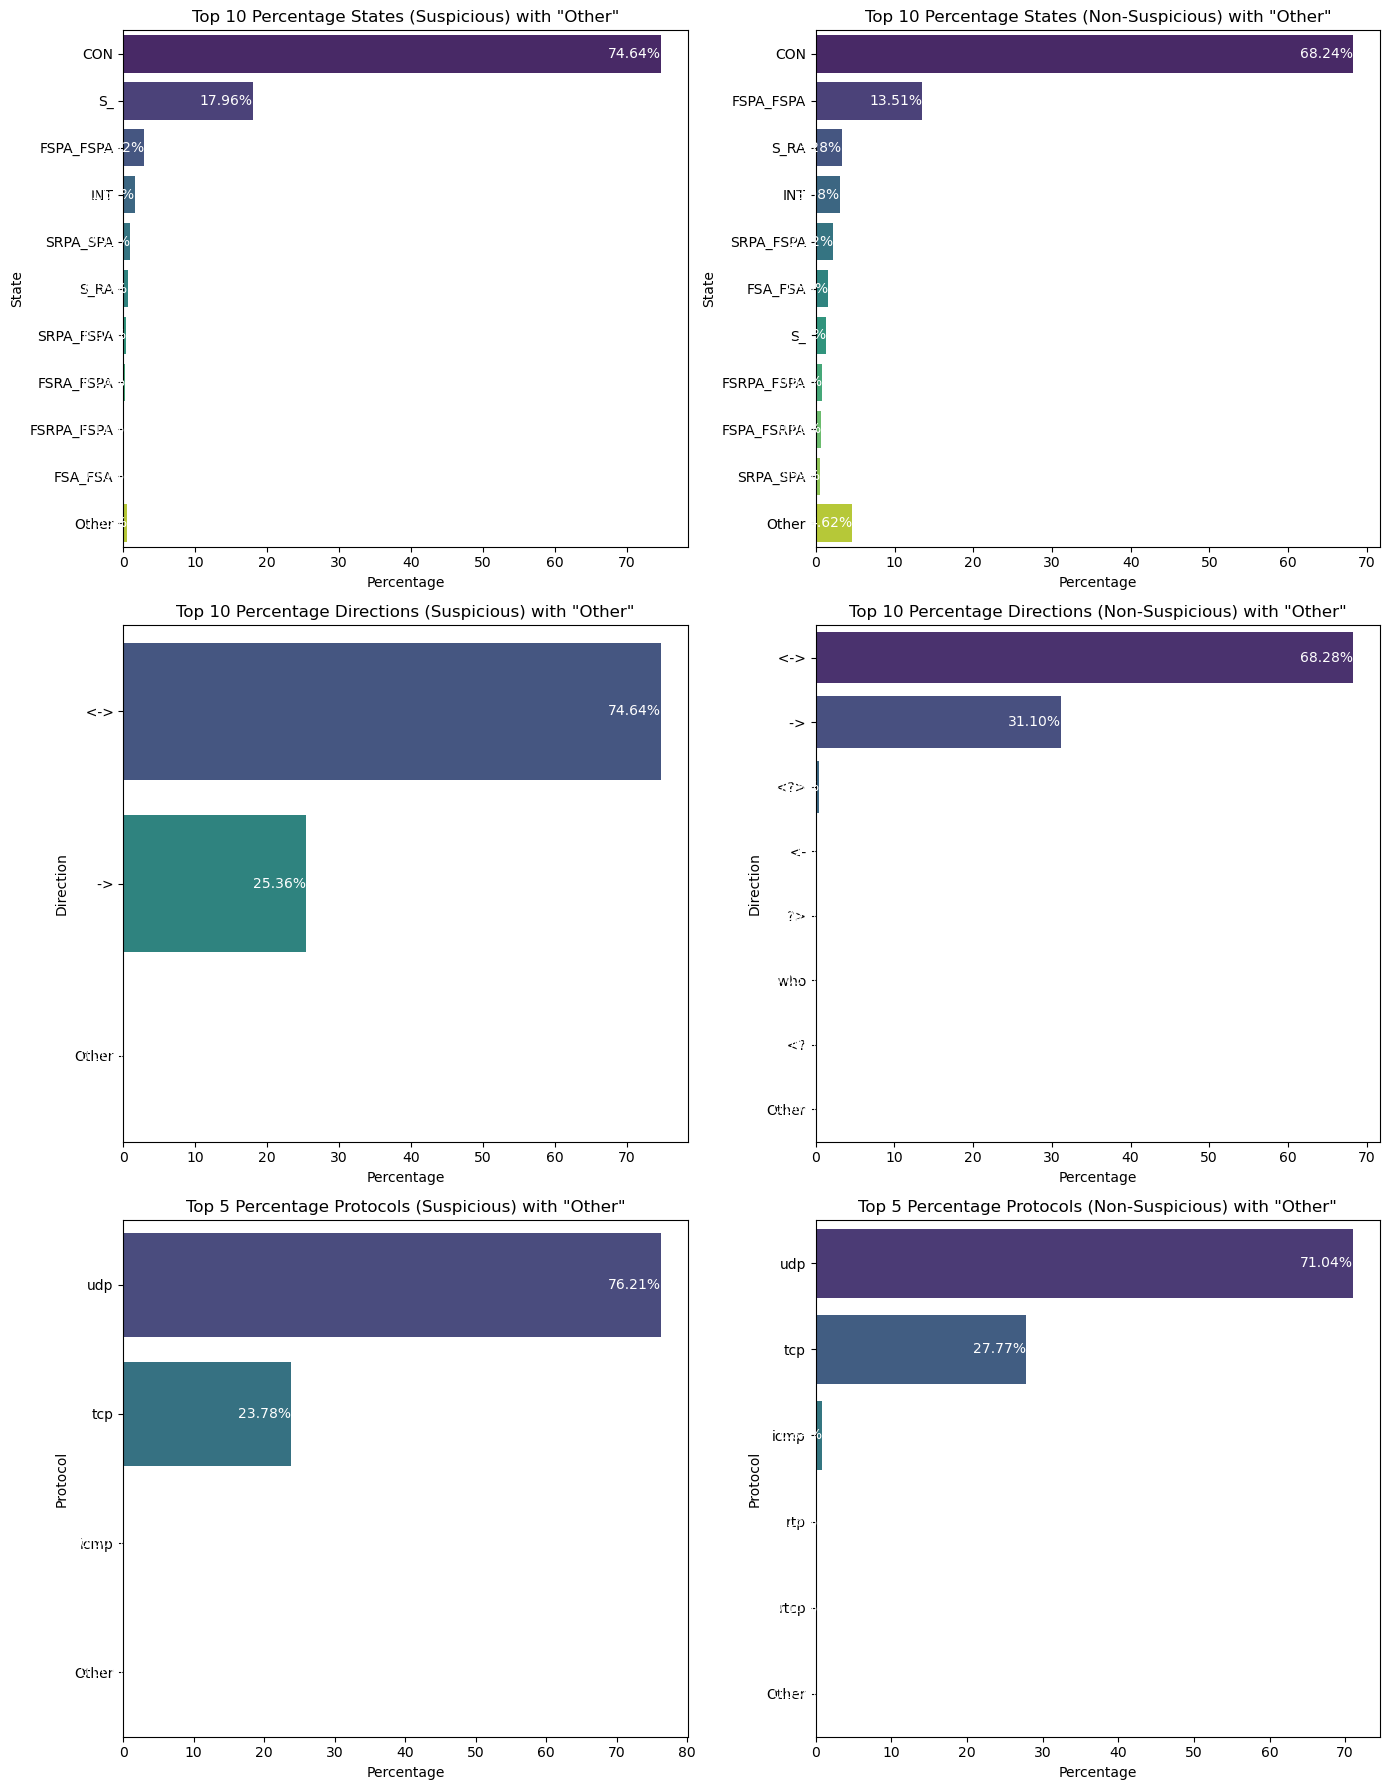

In [36]:
# Function to calculate top N categories by percentage and add 'Other' category
def top_n_percentage_with_other(df, col, n):
    category_counts = df[col].value_counts(normalize=True) * 100
    top_n_categories = category_counts.nlargest(n)
    other_percentage = category_counts.iloc[n:].sum()
    top_n_categories_with_other = pd.concat([top_n_categories, pd.Series({'Other': other_percentage})])
    return top_n_categories_with_other

top_10_states_suspicious_with_other = top_n_percentage_with_other(suspicious_df, 'State', 10)
top_10_states_non_suspicious_with_other = top_n_percentage_with_other(non_suspicious_df, 'State', 10)
top_10_direction_suspicious_with_other = top_n_percentage_with_other(suspicious_df, 'Direction', 10)
top_10_direction_non_suspicious_with_other = top_n_percentage_with_other(non_suspicious_df, 'Direction', 10)
top_5_protocol_suspicious_with_other = top_n_percentage_with_other(suspicious_df, 'Protocol', 5)
top_5_protocol_non_suspicious_with_other = top_n_percentage_with_other(non_suspicious_df, 'Protocol', 5)

# List of datasets and titles for plotting
plot_data = [
    (top_10_states_suspicious_with_other, 'Top 10 Percentage States (Suspicious) with "Other"', 'State', 1),
    (top_10_states_non_suspicious_with_other, 'Top 10 Percentage States (Non-Suspicious) with "Other"', 'State', 2),
    (top_10_direction_suspicious_with_other, 'Top 10 Percentage Directions (Suspicious) with "Other"', 'Direction', 3),
    (top_10_direction_non_suspicious_with_other, 'Top 10 Percentage Directions (Non-Suspicious) with "Other"', 'Direction', 4),
    (top_5_protocol_suspicious_with_other, 'Top 5 Percentage Protocols (Suspicious) with "Other"', 'Protocol', 5),
    (top_5_protocol_non_suspicious_with_other, 'Top 5 Percentage Protocols (Non-Suspicious) with "Other"', 'Protocol', 6)
]

plt.figure(figsize=(14, 18))

# Loop through data for plotting
for data, title, ylabel, position in plot_data:
    plt.subplot(3, 2, position)
    sns.barplot(x=data.values, y=data.index, palette='viridis')
    plt.title(title)
    plt.xlabel('Percentage')
    plt.ylabel(ylabel)
    for i, value in enumerate(data.values):
        plt.text(value, i, f'{value:.2f}%', va='center', ha='right', color='white')

# Adjust layout
plt.tight_layout()
plt.show()


**Keynotes from the categorical variables in relation to the target variable**
- 'State' Partially connect(S_) is the second most vulnerable 'State'.
- The uncommon 'Direction' such as  '<?', '?<', and the uncommon 'Protocol' such as 'rtp', and 'rtcp' are all found in the non_suspicious. This might be from the lack of enough observations of their kind, which might result in underfitting the ML model. 

Further exploration and analysis will help in identifying patterns and potential anomalies in the network traffic data.


- https://www.scribd.com/document/595632642/Telecommunications-Related-Abbreviations